# Learning to think like a jax vmap

In [1]:
import jax.numpy as jnp
from jax import vmap, random, jit
import matplotlib.pyplot as plt
from jax.image import resize

To help you structure your jax code to be vmap friendly, start with the outcome you are trying to achieve.

In this case I am going to start with an empty mosaic. I am going to then try to fill the mosaic using a vmap.

In [2]:
rows, cols = (10,10)
width, height = (100,100)
empty_mosaic = jnp.zeros((rows * height, cols * width))

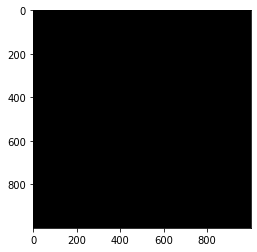

In [3]:
plt.imshow(empty_mosaic, vmax=1, vmin=0,  cmap='gray')
plt.show()

Vmap only vectorizes along a single access. This monochrome image has 2 axes. You can nest vmaps, but it looks messy. To really think like vmap, transform array onto a single axis. You can transform it back whenever you want to show it as an image.

In [4]:
flat_mosaic = jnp.ravel(empty_mosaic)
flat_mosaic.shape

(1000000,)

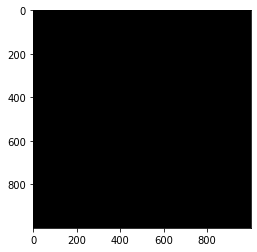

In [5]:
plt.imshow(jnp.reshape(flat_mosaic, empty_mosaic.shape),vmax=1, vmin=0,  cmap='gray')
plt.show()

Now lets get to work filling in the contents of our flattened mosaic using a dummy vmap.

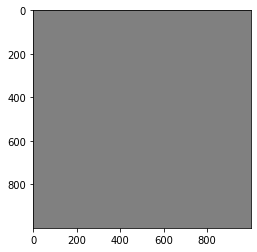

In [6]:
@jit
def transform(pixel):
    return 0.5

mosaic_1 = vmap(transform)(flat_mosaic)
plt.imshow(jnp.reshape(mosaic_1, empty_mosaic.shape), vmax=1, vmin=0,  cmap='gray')
plt.show()

Of course this isn't yet a mosaic, but we are going to do this bit by bit. All we have so far is a vectorizable function that transforms a pixel. Next we will introduce some randomness in that transformation.

To do that I am going to need to send random keys to my transform function. I will need a unique key for each cell. As long as my keys are an array with the same axis as my flat image, jax will cycle through them in sync with the image when performing the vectorized operation.

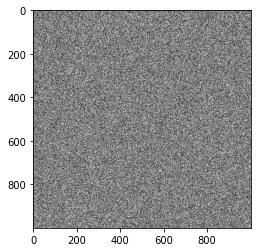

In [7]:
key = random.PRNGKey(29)
key, *keys = random.split(key,flat_mosaic.shape[0]+1)

@jit
def transform(pixel,key):
    return random.bernoulli(key,0.5,(1,))

mosaic_1 = vmap(transform)(flat_mosaic,jnp.array(keys))
plt.imshow(jnp.reshape(mosaic_1, empty_mosaic.shape), vmax=1, vmin=0,  cmap='gray')
plt.show()

This is still not a mosaic. We are looking to see a 10X10 grid. Inside each cell of this grid, we want a different greyscale value. At the moment the whole image has a random greyscale value of 0.5.

We will build a thumbnail to describe the desired brightness of each cell in the grid.

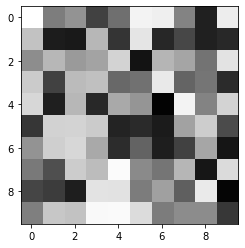

In [8]:
key, t_key = random.split(key)
thumbnail = random.uniform(t_key,minval=0,maxval=1, shape = (cols,rows))
plt.imshow(thumbnail, vmax=1, vmin=0,  cmap='gray')
plt.show()

How do we superimpose the brightness features of this 10X10 grid on a 1000 x 1000 image to turn it into a mosaic? To avoid looping and stick with what jax does so well - vmap - we need to get vmap to understand this thumbnail. Our vmapped transform function is operating on a 1M element flat array...so the answer is actually quite obvious. We need to turn this 10X10 array into 1M element flat array so that vmap can process it.

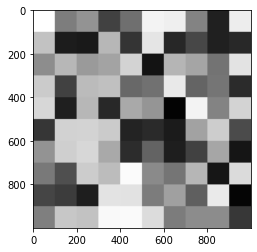

In [9]:
thumb = resize(thumbnail,method='nearest', shape = empty_mosaic.shape)
plt.imshow(thumb, vmax=1, vmin=0,  cmap='gray')

We are half way there.

In [10]:
flat_thumb = jnp.ravel(thumb)
flat_thumb.shape

(1000000,)

This flattened enlarged thumbnail image contains the features of the 10X10 image expanded into a vmap ready form. We just need to modify the transform function to use it. We do this by adding a new "brightness" argument and driving the probability value of our random number generator from this.

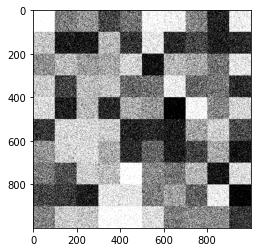

In [11]:
@jit
def transform(pixel,key,brightness):
    return random.bernoulli(key,brightness,(1,))

mosaic_1 = vmap(transform)(flat_mosaic,jnp.array(keys),flat_thumb)
plt.imshow(jnp.reshape(mosaic_1, empty_mosaic.shape), vmax=1, vmin=0,  cmap='gray')
plt.show()

Admittedly the mosaic above is no Mona Lisa, but all that is missing is a better thumbnail and a better transform function and the Mona Lisa is within reach. The structure is in place for producing an mosaic using monte carlo methods based on features derived from a thumbnail.

## Conclusions

1. The array contortions above may seem strange.
2. Perhaps they are strange, but they are simple, perform reasonably ok and are debuggable. My previous miss-adventures with working imperatively building up the mosaic one slice at a time may have been more intuitive, but it was a lot more complex and slow. It also turned out to be close to impossible for me as a noob to troubleshoot.
3. If you find yourself wrestling with jax like I did, I urge you to work backwards from your desired output. Transform that desired output into a form where you can execute a vectorized function over a single axis. Then transform all of the inputs so that they have the same shape as this common axis for vectorization. As long as you can do this, there is no need for wrestling. You can process the inputs element-wise inside the function that you vmap.
4. There is still a performance quirk that I would like to understand. A GPU would certainly speed things up, but on CPU this notebook takes over 2 minutes to run from start to finish. I would expect it to run in seconds.

Note: There is no need to transform scalar inputs or any other arrays that are going to act as constant values inside your vmapped function. You can use the "in_axes" vmap argument to designate if and how each input to the vmapped function should be processed.